### Question-Answering on SQUAD

In [16]:
# Import relevant libraries.
import torch
from huggingface_hub import notebook_login
import transformers
from datasets import load_dataset, load_metric

In [2]:
notebook_login()

### Loading the dataset

In [3]:
datasets = load_dataset("squad")

# Investigate a sample of the dataset.
datasets['train'][0]

Reusing dataset squad (C:\Users\srikanth\.cache\huggingface\datasets\squad\plain_text\1.0.0\d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [4]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML


indices = []
for _ in range(4):
    pick = random.randint(0, len(datasets['train'])-1)
    while pick in indices:
        pick = random.randint(0, len(datasets['train'])-1)
    indices.append(pick)
    

# Visualize 10 sample data points.
df = pd.DataFrame(datasets['train'][indices])
for col, typ in datasets['train'].features.items():
    if isinstance(typ, ClassLabel):
        df[col] = df[col].transform(lambda i: typ.names[i])
    elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
        df[col] = df[col].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

,id,title,context,question,answers
0,572a72f97a1753140016af89,Miami,"The surface bedrock under the Miami area is called Miami oolite or Miami limestone. This bedrock is covered by a thin layer of soil, and is no more than 50 feet (15 m) thick. Miami limestone formed as the result of the drastic changes in sea level associated with recent glaciations or ice ages. Beginning some 130,000 years ago the Sangamonian Stage raised sea levels to approximately 25 feet (8 m) above the current level. All of southern Florida was covered by a shallow sea. Several parallel lines of reef formed along the edge of the submerged Florida plateau, stretching from the present Miami area to what is now the Dry Tortugas. The area behind this reef line was in effect a large lagoon, and the Miami limestone formed throughout the area from the deposition of oolites and the shells of bryozoans. Starting about 100,000 years ago the Wisconsin glaciation began lowering sea levels, exposing the floor of the lagoon. By 15,000 years ago, the sea level had dropped to 300 to 350 feet (90 to 110 m) below the contemporary level. The sea level rose quickly after that, stabilizing at the current level about 4000 years ago, leaving the mainland of South Florida just above sea level.",How many meters did the Sangamonian Stage raise sea levels compared to their present level?,"{'text': ['8'], 'answer_start': [395]}"
1,56cda75062d2951400fa67c6,The_Legend_of_Zelda:_Twilight_Princess,"Twilight Princess was released to universal critical acclaim and commercial success. It received perfect scores from major publications such as 1UP.com, Computer and Video Games, Electronic Gaming Monthly, Game Informer, GamesRadar, and GameSpy. On the review aggregators GameRankings and Metacritic, Twilight Princess has average scores of 95% and 95 for the Wii version and scores of 95% and 96 for the GameCube version. GameTrailers in their review called it one of the greatest games ever created.",Who counted the game among the best ever made?,"{'text': ['GameTrailers'], 'answer_start': [423]}"
2,57267657708984140094c6f9,Mexico_City,"Originally much of the valley laid beneath the waters of Lake Texcoco, a system of interconnected salt and freshwater lakes. The Aztecs built dikes to separate the fresh water used to raise crops in chinampas and to prevent recurrent floods. These dikes were destroyed during the siege of Tenochtitlan, and during colonial times the Spanish regularly drained the lake to prevent floods. Only a small section of the original lake remains, located outside the Federal District, in the municipality of Atenco, State of Mexico.",Who first built the dikes in Lake Texcoco?,"{'text': ['The Aztecs'], 'answer_start': [125]}"
3,56cfe133234ae51400d9bfe3,New_York_City,"The city's total area is 468.9 square miles (1,214 km2). 164.1 sq mi (425 km2) of this is water and 304.8 sq mi (789 km2) is land. The highest point in the city is Todt Hill on Staten Island, which, at 409.8 feet (124.9 m) above sea level, is the highest point on the Eastern Seaboard south of Maine. The summit of the ridge is mostly covered in woodlands as part of the Staten Island Greenbelt.",How many feet above sea level is Todt Hil?,"{'text': ['409.8'], 'answer_start': [202]}"


,id,title,context,question,answers
0,572a72f97a1753140016af89,Miami,"The surface bedrock under the Miami area is called Miami oolite or Miami limestone. This bedrock is covered by a thin layer of soil, and is no more than 50 feet (15 m) thick. Miami limestone formed as the result of the drastic changes in sea level associated with recent glaciations or ice ages. Beginning some 130,000 years ago the Sangamonian Stage raised sea levels to approximately 25 feet (8 m) above the current level. All of southern Florida was covered by a shallow sea. Several parallel lines of reef formed along the edge of the submerged Florida plateau, stretching from the present Miami area to what is now the Dry Tortugas. The area behind this reef line was in effect a large lagoon, and the Miami limestone formed throughout the area from the deposition of oolites and the shells of bryozoans. Starting about 100,000 years ago the Wisconsin glaciation began lowering sea levels, exposing the floor of the lagoon. By 15,000 years ago, the sea level had dropped to 300 to 350 feet (90 to 110 m) below the contemporary level. The sea level rose quickly after that, stabilizing at the current level about 4000 years ago, leaving the mainland of South Florida just above sea level.",How many meters did the Sangamonian Stage raise sea levels compared to their present level?,"{'text': ['8'], 'answer_start': [395]}"
1,56cda75062d2951400fa67c6,The_Legend_of_Zelda:_Twilight_Princess,"Twilight Princess was released to universal critical acclaim and commercial success. It received perfect scores from major publications such as 1UP.com, Computer and Video Games, Electronic Gaming Monthly, Game Informer, GamesRadar, and GameSpy. On the review aggregators GameRankings and Metacritic, Twilight Princess has average scores of 95% and 95 for the Wii version and scores of 95% and 96 for the GameCube version. GameTrailers in their review called it one of the greatest games ever created.",Who counted the game among the best ever made?,"{'text': ['GameTrailers'], 'answer_start': [423]}"
2,57267657708984140094c6f9,Mexico_City,"Originally much of the valley laid beneath the waters of Lake Texcoco, a system of interconnected salt and freshwater lakes. The Aztecs built dikes to separate the fresh water used to raise crops in chinampas and to prevent recurrent floods. These dikes were destroyed during the siege of Tenochtitlan, and during colonial times the Spanish regularly drained the lake to prevent floods. Only a small section of the original lake remains, located outside the Federal District, in the municipality of Atenco, State of Mexico.",Who first built the dikes in Lake Texcoco?,"{'text': ['The Aztecs'], 'answer_start': [125]}"
3,56cfe133234ae51400d9bfe3,New_York_City,"The city's total area is 468.9 square miles (1,214 km2). 164.1 sq mi (425 km2) of this is water and 304.8 sq mi (789 km2) is land. The highest point in the city is Todt Hill on Staten Island, which, at 409.8 feet (124.9 m) above sea level, is the highest point on the Eastern Seaboard south of Maine. The summit of the ridge is mostly covered in woodlands as part of the Staten Island Greenbelt.",How many feet above sea level is Todt Hil?,"{'text': ['409.8'], 'answer_start': [202]}"


,id,title,context,question,answers
0,572a72f97a1753140016af89,Miami,"The surface bedrock under the Miami area is called Miami oolite or Miami limestone. This bedrock is covered by a thin layer of soil, and is no more than 50 feet (15 m) thick. Miami limestone formed as the result of the drastic changes in sea level associated with recent glaciations or ice ages. Beginning some 130,000 years ago the Sangamonian Stage raised sea levels to approximately 25 feet (8 m) above the current level. All of southern Florida was covered by a shallow sea. Several parallel lines of reef formed along the edge of the submerged Florida plateau, stretching from the present Miami area to what is now the Dry Tortugas. The area behind this reef line was in effect a large lagoon, and the Miami limestone formed throughout the area from the deposition of oolites and the shells of bryozoans. Starting about 100,000 years ago the Wisconsin glaciation began lowering sea levels, exposing the floor of the lagoon. By 15,000 years ago, the sea level had dropped to 300 to 350 feet (90 to 110 m) below the contemporary level. The sea level rose quickly after that, stabilizing at the current level about 4000 years ago, leaving the mainland of South Florida just above sea level.",How many meters did the Sangamonian Stage raise sea levels compared to their present level?,"{'text': ['8'], 'answer_start': [395]}"
1,56cda75062d2951400fa67c6,The_Legend_of_Zelda:_Twilight_Princess,"Twilight Princess was released to universal critical acclaim and commercial success. It received perfect scores from major publications such as 1UP.com, Computer and Video Games, Electronic Gaming Monthly, Game Informer, GamesRadar, and GameSpy. On the review aggregators GameRankings and Metacritic, Twilight Princess has average scores of 95% and 95 for the Wii version and scores of 95% and 96 for the GameCube version. GameTrailers in their review called it one of the greatest games ever created.",Who counted the game among the best ever made?,"{'text': ['GameTrailers'], 'answer_start': [423]}"
2,57267657708984140094c6f9,Mexico_City,"Originally much of the valley laid beneath the waters of Lake Texcoco, a system of interconnected salt and freshwater lakes. The Aztecs built dikes to separate the fresh water used to raise crops in chinampas and to prevent recurrent floods. These dikes were destroyed during the siege of Tenochtitlan, and during colonial times the Spanish regularly drained the lake to prevent floods. Only a small section of the original lake remains, located outside the Federal District, in the municipality of Atenco, State of Mexico.",Who first built the dikes in Lake Texcoco?,"{'text': ['The Aztecs'], 'answer_start': [125]}"
3,56cfe133234ae51400d9bfe3,New_York_City,"The city's total area is 468.9 square miles (1,214 km2). 164.1 sq mi (425 km2) of this is water and 304.8 sq mi (789 km2) is land. The highest point in the city is Todt Hill on Staten Island, which, at 409.8 feet (124.9 m) above sea level, is the highest point on the Eastern Seaboard south of Maine. The summit of the ridge is mostly covered in woodlands as part of the Staten Island Greenbelt.",How many feet above sea level is Todt Hil?,"{'text': ['409.8'], 'answer_start': [202]}"


,id,title,context,question,answers
0,572a72f97a1753140016af89,Miami,"The surface bedrock under the Miami area is called Miami oolite or Miami limestone. This bedrock is covered by a thin layer of soil, and is no more than 50 feet (15 m) thick. Miami limestone formed as the result of the drastic changes in sea level associated with recent glaciations or ice ages. Beginning some 130,000 years ago the Sangamonian Stage raised sea levels to approximately 25 feet (8 m) above the current level. All of southern Florida was covered by a shallow sea. Several parallel lines of reef formed along the edge of the submerged Florida plateau, stretching from the present Miami area to what is now the Dry Tortugas. The area behind this reef line was in effect a large lagoon, and the Miami limestone formed throughout the area from the deposition of oolites and the shells of bryozoans. Starting about 100,000 years ago the Wisconsin glaciation began lowering sea levels, exposing the floor of the lagoon. By 15,000 years ago, the sea level had dropped to 300 to 350 feet (90 to 110 m) below the contemporary level. The sea level rose quickly after that, stabilizing at the current level about 4000 years ago, leaving the mainland of South Florida just above sea level.",How many meters did the Sangamonian Stage raise sea levels compared to their present level?,"{'text': ['8'], 'answer_start': [395]}"
1,56cda75062d2951400fa67c6,The_Legend_of_Zelda:_Twilight_Princess,"Twilight Princess was released to universal critical acclaim and commercial success. It received perfect scores from major publications such as 1UP.com, Computer and Video Games, Electronic Gaming Monthly, Game Informer, GamesRadar, and GameSpy. On the review aggregators GameRankings and Metacritic, Twilight Princess has average scores of 95% and 95 for the Wii version and scores of 95% and 96 for the GameCube version. GameTrailers in their review called it one of the greatest games ever created.",Who counted the game among the best ever made?,"{'text': ['GameTrailers'], 'answer_start': [423]}"
2,57267657708984140094c6f9,Mexico_City,"Originally much of the valley laid beneath the waters of Lake Texcoco, a system of interconnected salt and freshwater lakes. The Aztecs built dikes to separate the fresh water used to raise crops in chinampas and to prevent recurrent floods. These dikes were destroyed during the siege of Tenochtitlan, and during colonial times the Spanish regularly drained the lake to prevent floods. Only a small section of the original lake remains, located outside the Federal District, in the municipality of Atenco, State of Mexico.",Who first built the dikes in Lake Texcoco?,"{'text': ['The Aztecs'], 'answer_start': [125]}"
3,56cfe133234ae51400d9bfe3,New_York_City,"The city's total area is 468.9 square miles (1,214 km2). 164.1 sq mi (425 km2) of this is water and 304.8 sq mi (789 km2) is land. The highest point in the city is Todt Hill on Staten Island, which, at 409.8 feet (124.9 m) above sea level, is the highest point on the Eastern Seaboard south of Maine. The summit of the ridge is mostly covered in woodlands as part of the Staten Island Greenbelt.",How many feet above sea level is Todt Hil?,"{'text': ['409.8'], 'answer_start': [202]}"


,id,title,context,question,answers
0,572a72f97a1753140016af89,Miami,"The surface bedrock under the Miami area is called Miami oolite or Miami limestone. This bedrock is covered by a thin layer of soil, and is no more than 50 feet (15 m) thick. Miami limestone formed as the result of the drastic changes in sea level associated with recent glaciations or ice ages. Beginning some 130,000 years ago the Sangamonian Stage raised sea levels to approximately 25 feet (8 m) above the current level. All of southern Florida was covered by a shallow sea. Several parallel lines of reef formed along the edge of the submerged Florida plateau, stretching from the present Miami area to what is now the Dry Tortugas. The area behind this reef line was in effect a large lagoon, and the Miami limestone formed throughout the area from the deposition of oolites and the shells of bryozoans. Starting about 100,000 years ago the Wisconsin glaciation began lowering sea levels, exposing the floor of the lagoon. By 15,000 years ago, the sea level had dropped to 300 to 350 feet (90 to 110 m) below the contemporary level. The sea level rose quickly after that, stabilizing at the current level about 4000 years ago, leaving the mainland of South Florida just above sea level.",How many meters did the Sangamonian Stage raise sea levels compared to their present level?,"{'text': ['8'], 'answer_start': [395]}"
1,56cda75062d2951400fa67c6,The_Legend_of_Zelda:_Twilight_Princess,"Twilight Princess was released to universal critical acclaim and commercial success. It received perfect scores from major publications such as 1UP.com, Computer and Video Games, Electronic Gaming Monthly, Game Informer, GamesRadar, and GameSpy. On the review aggregators GameRankings and Metacritic, Twilight Princess has average scores of 95% and 95 for the Wii version and scores of 95% and 96 for the GameCube version. GameTrailers in their review called it one of the greatest games ever created.",Who counted the game among the best ever made?,"{'text': ['GameTrailers'], 'answer_start': [423]}"
2,57267657708984140094c6f9,Mexico_City,"Originally much of the valley laid beneath the waters of Lake Texcoco, a system of interconnected salt and freshwater lakes. The Aztecs built dikes to separate the fresh water used to raise crops in chinampas and to prevent recurrent floods. These dikes were destroyed during the siege of Tenochtitlan, and during colonial times the Spanish regularly drained the lake to prevent floods. Only a small section of the original lake remains, located outside the Federal District, in the municipality of Atenco, State of Mexico.",Who first built the dikes in Lake Texcoco?,"{'text': ['The Aztecs'], 'answer_start': [125]}"
3,56cfe133234ae51400d9bfe3,New_York_City,"The city's total area is 468.9 square miles (1,214 km2). 164.1 sq mi (425 km2) of this is water and 304.8 sq mi (789 km2) is land. The highest point in the city is Todt Hill on Staten Island, which, at 409.8 feet (124.9 m) above sea level, is the highest point on the Eastern Seaboard south of Maine. The summit of the ridge is mostly covered in woodlands as part of the Staten Island Greenbelt.",How many feet above sea level is Todt Hil?,"{'text': ['409.8'], 'answer_start': [202]}"


### Preprocessing the data

The SQUAD dataset contains inputs in the form of title, context, question and answers. Here's the important inputs to be considered:

- Context: Paragraph where the answers to the questions are going to be found (if any)
- Question: Question asked, based on the context from the paragraph
- Answers: Annotated answers from the paragraph, with answer text, start index of the answer.

We need to convert these texts inputs into suitable vectors/tensors, which are fed into the models BERT, DistilBERT and XLNET. This conversion includes tokenization of the questions and answers. 

However, because we choose to only fine-tune BERT, DistilBERT and XLNET for SQUAD dataset, we have to retrieve the pretrained model checkpoints and the vocabulary used for pretraining these models. This can be retrieved using the HuggingFace transformers module.

For each of the model, we need to retrieve an independent tokenizer: BertTokenizer, XLNetTokenizer, DistilBertTokenizer
The reason behind different tokenization technique is because each of these models have been pre-trained based on different vocabulary and checkpoints (weights and biases). At the high level, the operations in a tokenizer include:
- Stripping whitespace characters
- Truncating and padding for identifying questions, answers and context

The outputs of tokenizer are used as inputs to the models.

### Converting text into Word Embeddings with Tokenizers

Consider the following example of a context and a question by BertTokenizer. It converts the context into a list of tokens.

In [13]:
from utils_squad import (get_squad_example_object, convert_example_to_model_inputs, write_predictions)
from transformers import (BertConfig, BertForQuestionAnswering, BertTokenizer)

context = "Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American entrepreneur, industrial designer, business magnate, media proprietor, and investor. He was the co-founder, the chairman, and CEO of Apple; the chairman and majority shareholder of Pixar; a member of The Walt Disney Company's board of directors following its acquisition of Pixar; and the founder, chairman, and CEO of NeXT. He is widely recognized as a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak."
question = 'Who is the founder of Apple?'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path='./Final_Checkpoints_Bert/Tokenizer', do_lower_case=True)
print(tokenizer.tokenize(context))

['steven', 'paul', 'jobs', '(', 'february', '24', ',', '1955', '–', 'october', '5', ',', '2011', ')', 'was', 'an', 'american', 'entrepreneur', ',', 'industrial', 'designer', ',', 'business', 'magnate', ',', 'media', 'proprietor', ',', 'and', 'investor', '.', 'he', 'was', 'the', 'co', '-', 'founder', ',', 'the', 'chairman', ',', 'and', 'ceo', 'of', 'apple', ';', 'the', 'chairman', 'and', 'majority', 'shareholder', 'of', 'pi', '##xa', '##r', ';', 'a', 'member', 'of', 'the', 'walt', 'disney', 'company', "'", 's', 'board', 'of', 'directors', 'following', 'its', 'acquisition', 'of', 'pi', '##xa', '##r', ';', 'and', 'the', 'founder', ',', 'chairman', ',', 'and', 'ceo', 'of', 'next', '.', 'he', 'is', 'widely', 'recognized', 'as', 'a', 'pioneer', 'of', 'the', 'personal', 'computer', 'revolution', 'of', 'the', '1970s', 'and', '1980s', ',', 'along', 'with', 'his', 'early', 'business', 'partner', 'and', 'fellow', 'apple', 'co', '-', 'founder', 'steve', 'wo', '##z', '##nia', '##k', '.']


In [14]:
# Each question, answer and context pair is converted into a squad example object, with ID, question text.

examples = get_squad_example_object(context, question)
examples

qas_id: 0, question_text: Who is the founder of Apple?, doc_tokens: [Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American entrepreneur, industrial designer, business magnate, media proprietor, and investor. He was the co-founder, the chairman, and CEO of Apple; the chairman and majority shareholder of Pixar; a member of The Walt Disney Company's board of directors following its acquisition of Pixar; and the founder, chairman, and CEO of NeXT. He is widely recognized as a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak.]

In [18]:
features = convert_example_to_model_inputs(examples, tokenizer, 384, 128, 64)
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

# Final vector embedding for the Squad example object.
print(all_input_ids)
print(all_input_mask)
print(all_segment_ids)
print(all_example_index)

tensor([[  101,  2040,  2003,  1996,  3910,  1997,  6207,  1029,   102,  7112,
          2703,  5841,  1006,  2337,  2484,  1010,  3982,  1516,  2255,  1019,
          1010,  2249,  1007,  2001,  2019,  2137, 10670,  1010,  3919,  5859,
          1010,  2449, 27470,  1010,  2865, 21584,  1010,  1998, 14316,  1012,
          2002,  2001,  1996,  2522,  1011,  3910,  1010,  1996,  3472,  1010,
          1998,  5766,  1997,  6207,  1025,  1996,  3472,  1998,  3484, 18668,
          1997, 14255, 18684,  2099,  1025,  1037,  2266,  1997,  1996, 10598,
          6373,  2194,  1005,  1055,  2604,  1997,  5501,  2206,  2049,  7654,
          1997, 14255, 18684,  2099,  1025,  1998,  1996,  3910,  1010,  3472,
          1010,  1998,  5766,  1997,  2279,  1012,  2002,  2003,  4235,  3858,
          2004,  1037,  7156,  1997,  1996,  3167,  3274,  4329,  1997,  1996,
          3955,  1998,  3865,  1010,  2247,  2007,  2010,  2220,  2449,  4256,
          1998,  3507,  6207,  2522,  1011,  3910,  

### Training & Evaluating the models [BERT, DistilBERT, XLNET]

Given computational time and memory constraints, we trained these models on GPUs in the Northeastern HPC server. The following are the command are used to train the models:

```python
python train.py --model 'bert'

python train.py --model 'distilbert'

python train.py --model 'xlnet'
```

For evaluation, the following commands are used (in which the checkpoints, pytorch trained models and tokenizers are required to be placed in the same directory):

```python

python evaluate.py --model 'bert'

python evaluate.py --model 'distilbert'

python evaluate.py --model 'xlnet'
```

### Compare the F1-scores and Exact Matches

In [20]:
# Paths for evaluated F1 scores and Exact Matches.
import os
import json

results_dir = os.path.join('./results')
bert_results = json.load(open(os.path.join(results_dir, 'Bert', 'result.json')))
distil_bert_results = json.load(open(os.path.join(results_dir, 'DistilBert', 'result.json')))
xlnet_bert_results = json.load(open(os.path.join(results_dir, 'Xlnet', 'result.json')))
results = [bert_results, distil_bert_results, xlnet_bert_results]

print(bert_results)
print(distil_bert_results)
print(xlnet_bert_results)

{'exact': 78.83632923368023, 'f1': 87.14188452907673, 'total': 10570, 'HasAns_exact': 78.83632923368023, 'HasAns_f1': 87.14188452907673, 'HasAns_total': 10570}
{'exact': 76.9441816461684, 'f1': 84.7536956876441, 'total': 10570, 'HasAns_exact': 76.9441816461684, 'HasAns_f1': 84.7536956876441, 'HasAns_total': 10570}
{'exact': 66.3197729422895, 'f1': 75.61597400828245, 'total': 10570, 'HasAns_exact': 66.3197729422895, 'HasAns_f1': 75.61597400828245, 'HasAns_total': 10570}


In [21]:
# Create a dataframe with the results.
f1_df = pd.DataFrame(columns=['model', 'score'])
f1_df['model'] = ['BERT', 'DistilBERT', 'XLNET']
f1_df['score'] = [result['f1'] for result in results]
f1_df['Metric'] = 'F1 Score'

em_df = pd.DataFrame(columns=['model', 'score'])
em_df['model'] = ['BERT', 'DistilBERT', 'XLNET']
em_df['score'] = [result['exact'] for result in results]
em_df['Metric'] = 'Exact Match'

final_df = pd.concat([f1_df, em_df])
final_df

,model,score,Metric
0,BERT,87.141885,F1 Score
1,DistilBERT,84.753696,F1 Score
2,XLNET,75.615974,F1 Score
0,BERT,78.836329,Exact Match
1,DistilBERT,76.944182,Exact Match
2,XLNET,66.319773,Exact Match


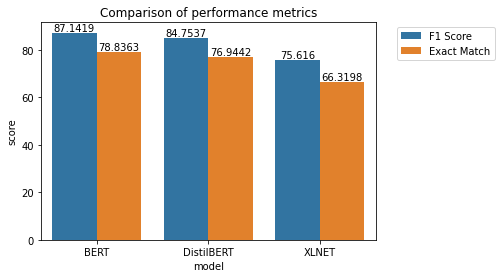

In [22]:
# Plot a bar graph.
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x = 'model', y = 'score', hue = 'Metric', data = final_df)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
lgd = plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Comparison of performance metrics')
plt.savefig('metrics-comparison.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

Here's a few inferences from the result above:

1. We can clearly see that the performance of BERT is the best among the three models, with DistilBERT almost behind BERT.
2. As the number of epochs increase, we suppose that XLNET performs better to achieve higher scores.

### Compare the latency of each model

In [4]:
from qa_system import *
import time

# Test question:
context = "Steve Jobs was an American entrepreneur, industrial designer, business magnate and investor. \
           He was widely recognized as a pioneer of the personal computer revolution of the 1970s and 1980s,\
           along with his early business partner and fellow Apple co-founder Steve Wozniak.\
           He was born on 24th February 1955 in San Francisco. He and Wozniak co-founded Apple \
           in 1976 to sell Wozniak's Apple I personal computer. The Macintosh introduced the desktop \
           publishing industry in 1985 with the addition of the Apple LaserWriter, the first laser printer\
           to feature vector graphics."
question = "who co-founded Apple?"

# Test BERT model speed.
bert_start = time.time()
model = Model(
    model_type = 'bert',
    model_path = './Final_Checkpoints_Bert',
    tokenizer_path = './Final_Checkpoints_Bert/tokenizer')
bert_answer = model.predict(context, question)
bert_end = time.time()
print('Time taken for answering by BERT: ', bert_end - bert_start)

# Test DistilBERT model speed.
dbert_start = time.time()
model = Model(
    model_type = 'bert',
    model_path = './Final_Checkpoints_DistilBert',
    tokenizer_path = './Final_Checkpoints_DistilBert/tokenizer')
dbert_answer = model.predict(context, question)
dbert_end = time.time()
print('Time taken for answering by DistilBert BERT: ', dbert_end - dbert_start)

# Test XLNET model speed.
xlnet_start = time.time()
model = Model(
    model_type = 'bert',
    model_path = './Final_Checkpoints_Bert',
    tokenizer_path = './Final_Checkpoints_Bert/tokenizer')
xlnet_answer = model.predict(context, question)
xlnet_end = time.time()
print('Time taken for answering by XLNET: ', xlnet_end - xlnet_start)

# Create a DataFrame with the time for each method.
latency_df = pd.DataFrame()
latency_df['Model'] = ['Bert', 'DistilBert', 'XLNET']
latency_df['Time per question (ms)'] = [int((bert_end-bert_start) * 100), int((dbert_end-dbert_start) * 100), int((xlnet_end-xlnet_start) * 100)]
latency_df

Time taken for answering by BERT:  2.560497283935547
Time taken for answering by DistilBert BERT:  0.9830152988433838
Time taken for answering by XLNET:  2.484772205352783


,Model,Time per question (ms)
0,Bert,256
1,DistilBert,98
2,XLNET,248


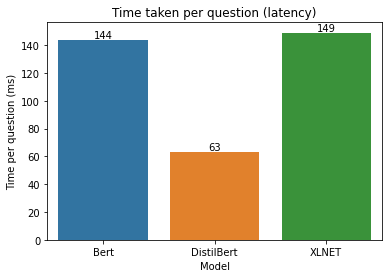

In [24]:
ax = sns.barplot(x = 'Model', y = 'Time per question (ms)', data = latency_df)
ax.bar_label(ax.containers[0])
plt.title('Time taken per question (latency)')
plt.savefig('latency.png')
plt.show()

From the graph above, we can see that clearly DistilBert is the fastest among the models to provide answer for a question with a context. This also conforms with the concept of knowledge distillation and makes DistilBERT model an ideal model for high latency requirements, such as search engines or chat-bots / personal assistants.

### Comparison for test question, context and answer

In [6]:
context = "Steve Jobs was an American entrepreneur, industrial designer, business magnate and investor. \
           He was widely recognized as a pioneer of the personal computer revolution of the 1970s and 1980s,\
           along with his early business partner and fellow Apple co-founder Steve Wozniak.\
           He was born on 24th February 1955 in San Francisco. He and Wozniak co-founded Apple \
           in 1976 to sell Wozniak's Apple I personal computer. The Macintosh introduced the desktop \
           publishing industry in 1985 with the addition of the Apple LaserWriter, the first laser printer\
           to feature vector graphics."
question = "who co-founded Apple?"

print('Answer from bert:', bert_answer['answer'])
print('Answer from distilbert:', dbert_answer['answer'])
print('Answer from xlnet:', xlnet_answer['answer'])

Answer from bert: Steve Wozniak
Answer from distilbert: Steve Wozniak
Answer from xlnet: Steve Wozniak


We can clearly see that the models are producing similar answers to the same question.